<a href="https://colab.research.google.com/github/abhinav9629/DCGAN_FashionMNIST/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
(train_img,train_tar),(test_img,test_tar) =keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_img.shape,test_img.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
#MODEL -> GENERATOR -> Will return 28X28X1 images.

In [5]:
def Generator():
  generator = keras.Sequential([
      keras.layers.Dense(7*7*128,input_shape=(100,)),
      keras.layers.Reshape((7,7,128)),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Conv2DTranspose(filters=128,kernel_size=(5,5),strides=(2,2),padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5),strides=(2,2),padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5),strides=(1,1),padding='same'),
      
      keras.layers.BatchNormalization(),
      keras.layers.Conv2DTranspose(filters=1,kernel_size=(5,5),strides=(1,1),activation='tanh',padding='same'),
  ])
  return generator

In [6]:
#MODEL -> DISCRIMINATOR ->

In [7]:
def Discriminator():
  discriminator = keras.Sequential([
      keras.layers.Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same'),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(128,kernel_size=(5,5),strides=(1,1),padding='same'),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(256,kernel_size=(5,5),strides=(1,1),padding='same'),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.3),

      keras.layers.Flatten(),
      keras.layers.Dense(1,activation='sigmoid')
  ])
  return discriminator

In [8]:
def build_models():
    
    lr = 2e-4
    decay = 6e-8
    
    base_discriminator = Discriminator()
    
    discriminator = keras.models.Model(inputs=base_discriminator.inputs,outputs=base_discriminator.outputs)
    optimizer = keras.optimizers.RMSprop(learning_rate = lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    generator = Generator()
    
    frozen_discriminator = keras.models.Model(inputs=base_discriminator.inputs,outputs=base_discriminator.outputs)
    frozen_discriminator.trainable = False
    optimizer = keras.optimizers.RMSprop(learning_rate = lr * 0.5, decay=decay * 0.5)
    
    adversarial = keras.models.Model(generator.input,frozen_discriminator(generator.output))
    adversarial.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

In [9]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(4,4))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [13]:
def train_process(generator,discriminator,adversarial,noise_size=100):
  batch_size = 64
  epochs = 100000

  (train_input,train_target),(test_input,test_target) = keras.datasets.fashion_mnist.load_data()

  train_input = train_input.astype('float32')/255
  test_noise_input = np.random.uniform(-1.0,1.0,size=[16,noise_size])

  for step in range(epochs):
    noise_input = np.random.uniform(-1.0,1.0,size=[batch_size,noise_size])
    fake_images = generator.predict(noise_input)

    img_indexes = np.random.randint(0, train_input.shape[0], size=batch_size)
    real_images = train_input[img_indexes]
    real_images = real_images.reshape(batch_size, 28, 28, 1)

    X = np.concatenate((real_images,fake_images))

    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    y = np.concatenate((y_real, y_fake))

    discri_loss, discri_acc = discriminator.train_on_batch(X, y)

    X = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
    y = np.ones((batch_size, 1))

    adversarial_loss, adversarial_accuracy = adversarial.train_on_batch(X, y)

    if step % 1000 == 0:            
      print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (step, discri_loss, discri_acc, adversarial_loss, adversarial_accuracy) )
      fake_images = generator.predict(test_noise_input)
      plot_images(fake_images, step+1)

In [11]:
train_generator, train_discriminator, train_adversarial = build_models()

0 [Discriminator loss: 0.029556, acc: 0.992188, Adversarial loss: 0.595265, acc: 0.671875]


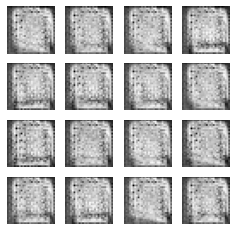

1000 [Discriminator loss: 0.012493, acc: 1.000000, Adversarial loss: 1.355094, acc: 0.453125]


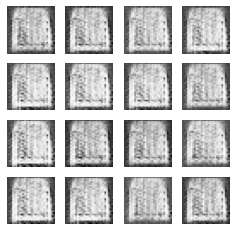

2000 [Discriminator loss: 0.000685, acc: 1.000000, Adversarial loss: 17.502556, acc: 0.000000]


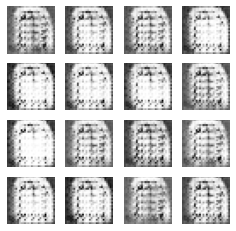

3000 [Discriminator loss: 0.001824, acc: 1.000000, Adversarial loss: 2.902170, acc: 0.406250]


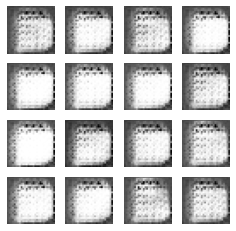

4000 [Discriminator loss: 0.018457, acc: 0.992188, Adversarial loss: 1.755383, acc: 0.390625]


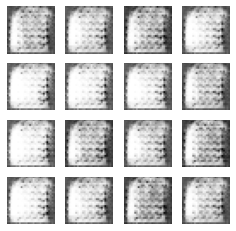

5000 [Discriminator loss: 0.000384, acc: 1.000000, Adversarial loss: 0.151127, acc: 0.937500]


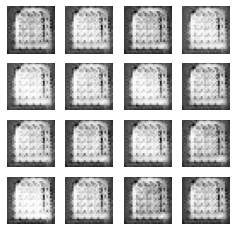

6000 [Discriminator loss: 0.000005, acc: 1.000000, Adversarial loss: 10.208113, acc: 0.000000]


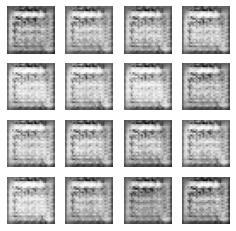

7000 [Discriminator loss: 0.000340, acc: 1.000000, Adversarial loss: 10.763842, acc: 0.109375]


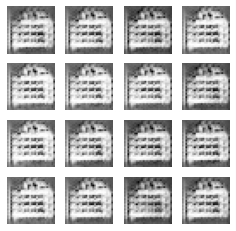

8000 [Discriminator loss: 0.000535, acc: 1.000000, Adversarial loss: 5.858482, acc: 0.000000]


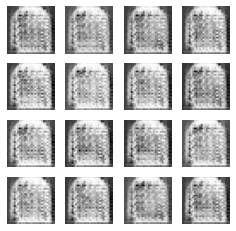

9000 [Discriminator loss: 0.008002, acc: 0.992188, Adversarial loss: 7.972247, acc: 0.156250]


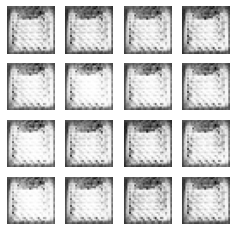

10000 [Discriminator loss: 0.062500, acc: 0.992188, Adversarial loss: 7.217216, acc: 0.171875]


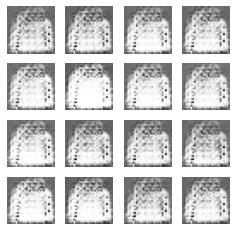

11000 [Discriminator loss: 0.000078, acc: 1.000000, Adversarial loss: 5.705274, acc: 0.031250]


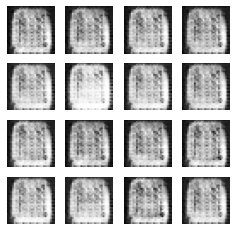

12000 [Discriminator loss: 0.000013, acc: 1.000000, Adversarial loss: 3.985631, acc: 0.453125]


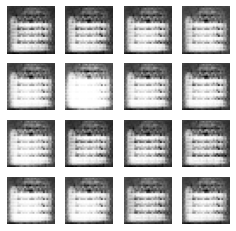

13000 [Discriminator loss: 0.009291, acc: 1.000000, Adversarial loss: 9.161194, acc: 0.015625]


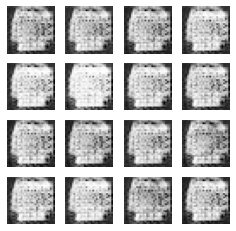

14000 [Discriminator loss: 0.003488, acc: 1.000000, Adversarial loss: 9.070397, acc: 0.203125]


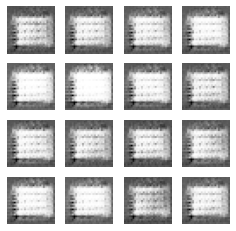

15000 [Discriminator loss: 0.001911, acc: 1.000000, Adversarial loss: 7.346514, acc: 0.031250]


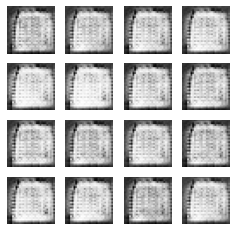

16000 [Discriminator loss: 0.053733, acc: 0.984375, Adversarial loss: 28.444298, acc: 0.000000]


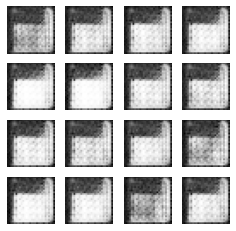

17000 [Discriminator loss: 0.000052, acc: 1.000000, Adversarial loss: 2.094073, acc: 0.609375]


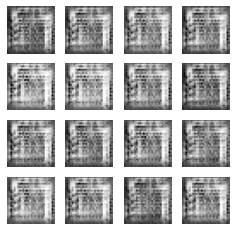

18000 [Discriminator loss: 0.000101, acc: 1.000000, Adversarial loss: 1.617782, acc: 0.640625]


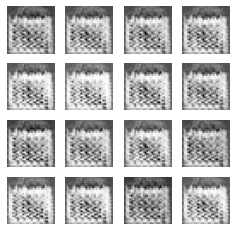

19000 [Discriminator loss: 0.000223, acc: 1.000000, Adversarial loss: 5.257326, acc: 0.421875]


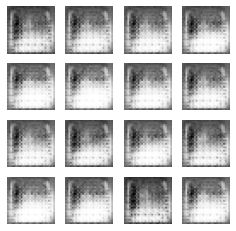

20000 [Discriminator loss: 0.019119, acc: 0.992188, Adversarial loss: 7.179326, acc: 0.015625]


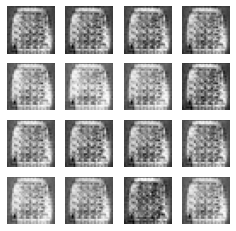

21000 [Discriminator loss: 0.000151, acc: 1.000000, Adversarial loss: 7.745712, acc: 0.015625]


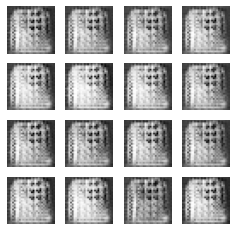

22000 [Discriminator loss: 0.018792, acc: 0.992188, Adversarial loss: 5.799726, acc: 0.031250]


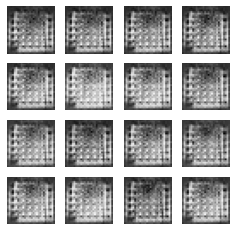

23000 [Discriminator loss: 0.001157, acc: 1.000000, Adversarial loss: 3.969514, acc: 0.375000]


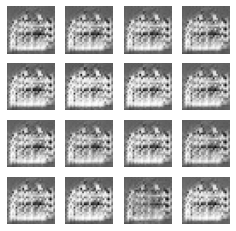

24000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 10.260752, acc: 0.031250]


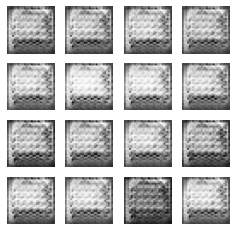

25000 [Discriminator loss: 0.235475, acc: 0.929688, Adversarial loss: 22.698793, acc: 0.000000]


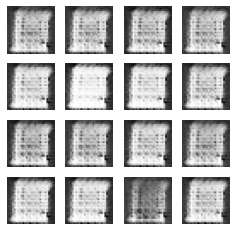

26000 [Discriminator loss: 0.000013, acc: 1.000000, Adversarial loss: 0.704987, acc: 0.921875]


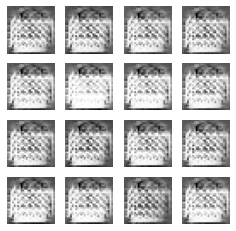

27000 [Discriminator loss: 0.000033, acc: 1.000000, Adversarial loss: 1.787215, acc: 0.687500]


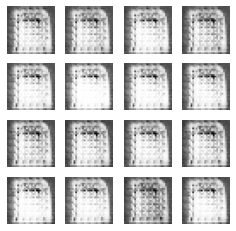

28000 [Discriminator loss: 0.001641, acc: 1.000000, Adversarial loss: 0.068566, acc: 0.953125]


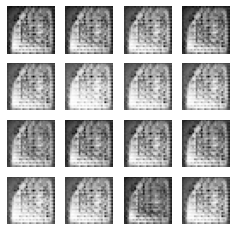

29000 [Discriminator loss: 0.000051, acc: 1.000000, Adversarial loss: 8.926721, acc: 0.187500]


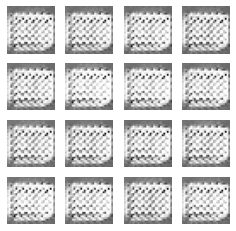

30000 [Discriminator loss: 0.007007, acc: 0.992188, Adversarial loss: 13.749266, acc: 0.015625]


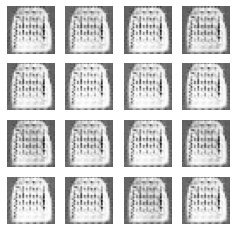

31000 [Discriminator loss: 0.000139, acc: 1.000000, Adversarial loss: 1.396351, acc: 0.703125]


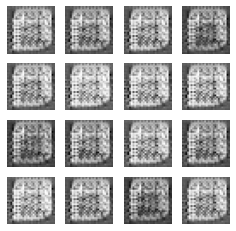

32000 [Discriminator loss: 0.011889, acc: 0.992188, Adversarial loss: 12.017294, acc: 0.296875]


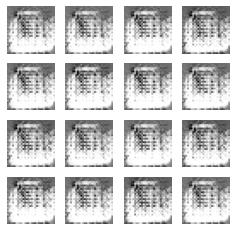

33000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 20.763355, acc: 0.000000]


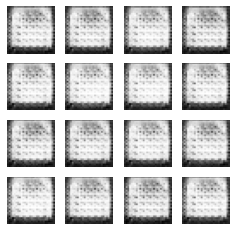

34000 [Discriminator loss: 0.000695, acc: 1.000000, Adversarial loss: 0.002724, acc: 1.000000]


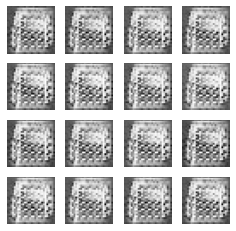

35000 [Discriminator loss: 0.000008, acc: 1.000000, Adversarial loss: 1.140431, acc: 0.750000]


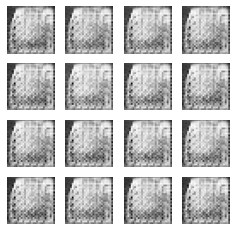

36000 [Discriminator loss: 0.000001, acc: 1.000000, Adversarial loss: 21.284910, acc: 0.015625]


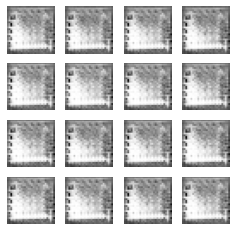

37000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 27.852388, acc: 0.000000]


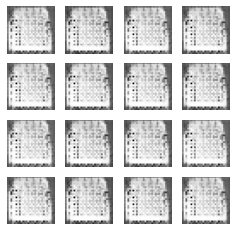

38000 [Discriminator loss: 0.000544, acc: 1.000000, Adversarial loss: 5.488081, acc: 0.406250]


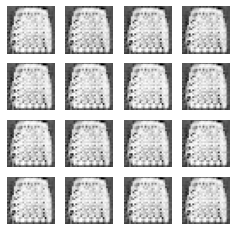

39000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 14.000332, acc: 0.015625]


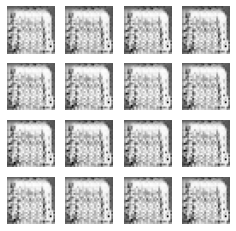

40000 [Discriminator loss: 0.036795, acc: 0.992188, Adversarial loss: 0.001927, acc: 1.000000]


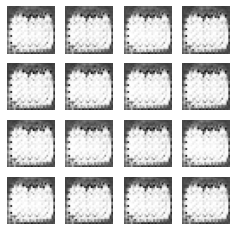

41000 [Discriminator loss: 0.035230, acc: 0.992188, Adversarial loss: 38.645664, acc: 0.000000]


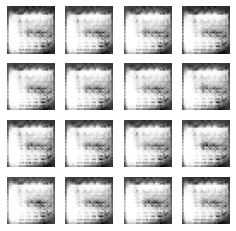

42000 [Discriminator loss: 0.033255, acc: 0.992188, Adversarial loss: 49.568199, acc: 0.000000]


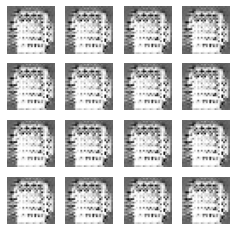

43000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 1.482791, acc: 0.937500]


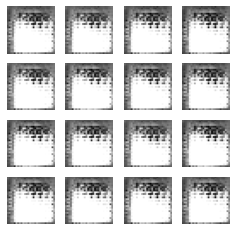

44000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 31.681471, acc: 0.000000]


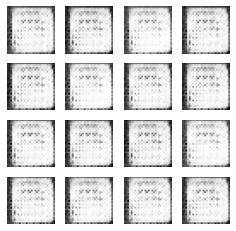

45000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 0.019706, acc: 1.000000]


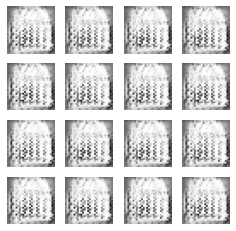

46000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 36.341557, acc: 0.000000]


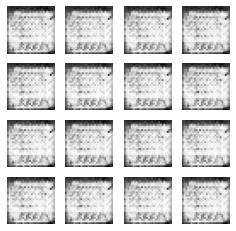

47000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 28.167950, acc: 0.000000]


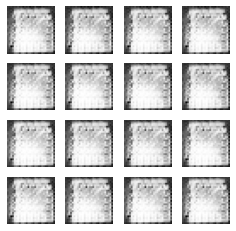

48000 [Discriminator loss: 0.000003, acc: 1.000000, Adversarial loss: 0.000001, acc: 1.000000]


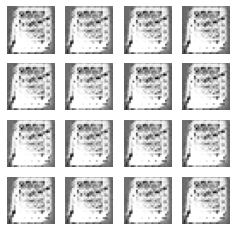

49000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 23.729645, acc: 0.015625]


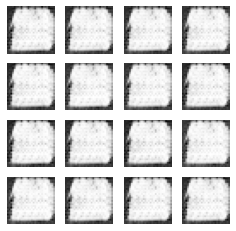

50000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 21.400959, acc: 0.000000]


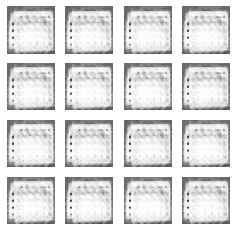

51000 [Discriminator loss: 0.153263, acc: 0.992188, Adversarial loss: 0.000532, acc: 1.000000]


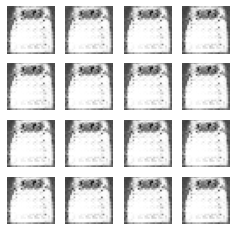

52000 [Discriminator loss: 0.240151, acc: 0.953125, Adversarial loss: 78.311569, acc: 0.000000]


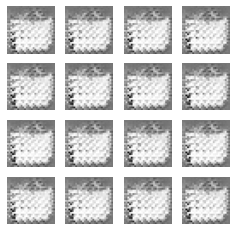

53000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 35.006935, acc: 0.062500]


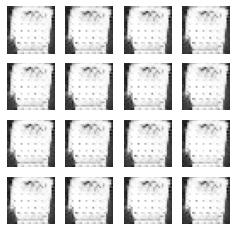

54000 [Discriminator loss: 0.000032, acc: 1.000000, Adversarial loss: 15.185672, acc: 0.062500]


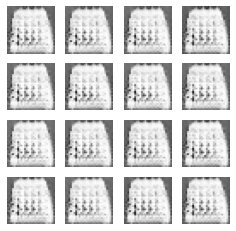

55000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 0.000028, acc: 1.000000]


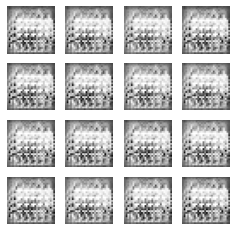

56000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 60.587807, acc: 0.015625]


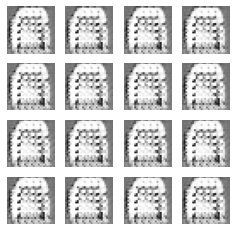

57000 [Discriminator loss: 0.432723, acc: 0.984375, Adversarial loss: 44.779930, acc: 0.000000]


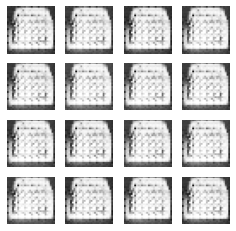

58000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 30.865582, acc: 0.015625]


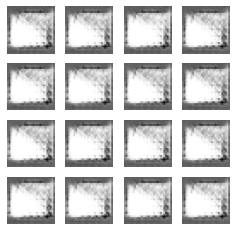

59000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 14.909549, acc: 0.062500]


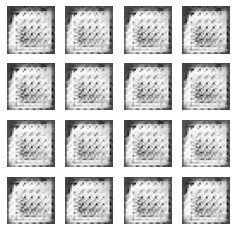

60000 [Discriminator loss: 0.000000, acc: 1.000000, Adversarial loss: 0.066377, acc: 0.984375]


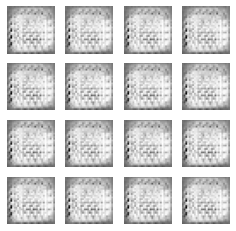

61000 [Discriminator loss: 0.039884, acc: 0.992188, Adversarial loss: 0.000000, acc: 1.000000]


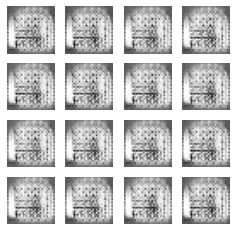

In [ ]:
train_process(train_generator,train_discriminator,train_adversarial)
